# Apresentação de papers (Gerência Analytics Produtos): Carlo 24/01/2020

Essa apresentação é fortemente inspirada em um [notebook do Kraggle](https://www.kaggle.com/matheusfacure/semi-supervised-anomaly-detection-survey) do [Matheus Facure](https://matheusfacure.github.io/) que testa e discute a utilização desses métodos para identificação de fraudes em transações bancárias. A ideia inicial era reproduzir os principais resultados, mas adaptei o material focando mais na visualização, por isso vamos aplicar os modelos em um dataset toy com apenas duas features.

# Detecção de anomalias utilizando métodos semi-supervisionados

Quando lidamos com problemas muito desbalanceados as técnicas usuais de classificação supervisionadas podem não ser a melhor estratégia. Dependendo do que o método otimiza, podemos ter situações com acurácia alta, mas porque o método prevê que todos os elementos são da classe dominante. Isso não é ideal.

Existem técnicas que tentam deixar as classes mais equilibradas criando novos elementos da classe minoritária ou excluindo elementos da dominante. Essas são as técnicas de [oversampling e undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis), respectivamente.

Nesse notebook discutiremos uma abordagem diferente da utilizada tradicionamente em problemas de classificação. Vamos aproveitar a forma como alguns algoritmos não-supervisionados são criados para encontrar regiões de normalidade (regiões com grande concentração de exemplos da classe dominante).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import seaborn as sns 
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

np.random.seed(42)

# Criação de um dataset toy para visualizar, testar e comparar os métodos

In [2]:
number_examples=50000 #>1000

X1 = []
X2 = []
y = []

for i in range(number_examples):
    classe = np.random.binomial(1,0.008)
    y.append(classe)
    if classe == 0:
        auX1 = np.random.normal(0,0.5)
        auX2 = np.random.normal(0,1)
        aux = np.random.binomial(1,0.03)
        if aux == 0:
            X1.append(1+0.3*auX1+0.5*auX2)
            X2.append(0.3+0.5*auX1-0.5*auX2)
        else:
            X1.append(-1.2+0.3*auX1)
            X2.append(-0.6-0.5*auX2) 
    else:
        coin = np.random.binomial(1,0.2)
        if coin == 0:
            aux = np.random.binomial(1,0.5)
            X1.append(np.random.normal(3,1))
            X2.append(-2+4*aux + np.random.normal(0,1))
        else:
            X1.append(np.random.normal(-0.2,0.8))
            X2.append(np.random.normal(-0.8,0.5))
    
X1 = np.asarray(X1)
X2 = np.asarray(X2)
y  = np.asarray(y)

df = pd.DataFrame(np.transpose(np.asarray([X1,X2,y])),columns=['X1','X2','y'])

df.head()

,X1,X2,y
0,0.992669,-0.137421,0.0
1,1.547114,-0.135497,0.0
2,0.650283,0.417365,0.0
3,1.083302,-0.828322,0.0
4,0.564590,0.564192,0.0


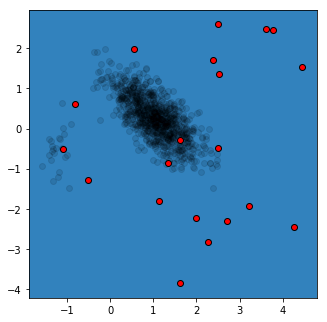

In [3]:
fig = plt.figure(figsize=(5,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

ax.set_facecolor("#3282BD")
plt.scatter(X1[np.where(y == 0)][:1000],X2[np.where(y == 0)][:1000],alpha=0.1,c='black')
plt.scatter(X1[np.where(y == 1)][:20],X2[np.where(y == 1)][:20],alpha=1,c='red',edgecolors='black')

plt.show()

Número de elementos normais: 49631
Número de anomalias: 369
Proporção: 0.074349%


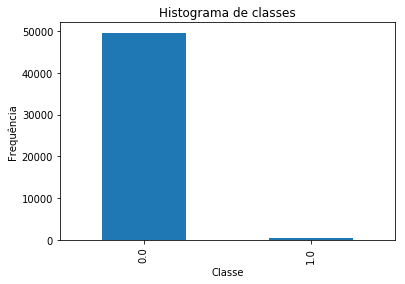

In [4]:
count_classes = pd.value_counts(df['y'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Histograma de classes")
plt.xlabel("Classe")
plt.ylabel("Frequência")

print('Número de elementos normais: '+str(df[df['y'] == 0].shape[0]))
print('Número de anomalias: '+str(df[df['y'] == 1].shape[0]))
print('Proporção: '+str(np.round(10*df[df['y'] == 1].shape[0]/df[df['y'] == 0].shape[0],6))+'%')

# Métricas de avaliação

Quando trabalhamos com dados muito desbalanceados, temos que entender muito bem o que queremos ter como métrica de eficiência do modelo. Como já comentado, um modelo que, no nosso caso chutasse que todos os exemplos são da classe 0 acertaria mais que 99.9% das vezes, mas ele está aprendendo alguma coisa com os dados?

A **precisão** $P$ é definida como o número de verdadeiros positivos $T_p$ sobre o número total de previsões positivas (ou seja, o número de verdadeiros positivos de falsos positivos $F_p$):

$$ P = \frac{T_p}{T_p + F_p} .$$

O **recall** $R$ é definido com o número de verdadeiros positivos sobre o número total de positivos da base (ou seja, os verdadeiros positivos e os falsos negativos $F_n$):

$$ R = \frac{T_p}{T_p + F_n} .$$

Um sistema com alto recall, mas com baixa precisão fala que varios exemplos são positivos, mas muito desses exemplos eram na verdade da classe negativa. Por outro lado, um sistema com baixo recall e alta precisão fala que muitos dos exemplos positivos na verdade eram negativos, mas os poucos exemplos que chuta com positivo realmente eram positivos.

Uma forma de combinar as duas métricas é usando as métricas de $F_\beta$ score:

$$ F_\beta = (1+\beta)^2 \frac{R * P}{\beta^2 * P + R} .$$

A escolha do $\beta$ depende do que queremos entender.

* Para dar mais peso para a precisão, pegamos $\beta \in \,\, ]0,1[$.
* Para dar mais peso para o recall, escolhemos $\beta \in \,\, ]1,\infty[$.
* Quando $\beta=1$, o peso é igual.

Como no [artigo do Kraggle](https://www.kaggle.com/matheusfacure/semi-supervised-anomaly-detection-survey) original que baseio essa apresentação é utilizado $\beta = 2$ pela motivação do problema, vamos manter esse valor.

# Idéia dos métodos e avaliação:

A validação de modelos com essas abordagens semi-supervisionadas ocorrem separando nossos dados em três grupos:

* No primeiro grupo, selecionamos uma grande parte dos **dados normais**. Com algum algoritmo não-supervisionado definimos as regiões do espaço com maior concentração de dados normais e um score para nos informar o quão normal um dado é.
* No segundo grupo, **variamos o threshold em um conjunto de validação (com dados normais e anormais)** para definir se um exemplo é normal ou anomalia e buscamos os melhores hiperparamêtros do modelo em relação a alguma métrica (como precisão, recall etc).
* No terceiro grupo, em um conjunto de **dados nunca visto pelo modelo**, **analisamos as métricas** e temos uma previsão real de como nosso modelo se comportaria com dados novos.

<img src="validacao.png">
Os dados em preto são os normais, os dados em vermelho são as anomalias.

In [5]:
normal = df[df['y'] == 0]
anomaly = df[df['y'] == 1]

from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).reset_index(drop=True)
test = normal_test.append(anormal_test).reset_index(drop=True)

# Ideia principal de detecção de anomalia utilizando métodos semi-supervisionados

A ideia para determinar regiões de normalidade é utilizando modelos baseados em distribuições de densidade (ou modelos que dão um score de quão mais dentro de uma região estamos).

Assumimos que os nossos dados **normais** são gerados por uma distribuição com densidade de probabilidade $f(x)$. Dado uma amostra nova $\hat{x}$ calculamos a verossimelhança relativa como $f(\hat{x})$. Escolhemos um limiar $\varepsilon$ e dizemos que:
* $\hat{x}$ é um exemplo normal se $f(\hat{x}) \geq \varepsilon$;
* $\hat{x}$ é uma anomalia se $f(\hat{x}) < \varepsilon$.

Fitamos essa distribuição (ou algo análogo que nos retorne um score de o quão "normal" o exemplo é) com alguma técnica não supervisionada.

# 1) Cada variável é uma distribuição gaussiana independente

Esse é o primeiro exemplo dado pelo Andrew Ng na suas [aulas de detecção de anomalia](https://www.youtube.com/playlist?list=PLwgXNx7TiGV6UH3aEzmdZwzFRwvEnRb0N).

Com essa técnica, assumimos que nossos dados são gerados por uma distribuição normal. Podemos fitar as distribuições utilizando os estimadores de máxima verossimelhança.

Como assumimos independência, podemos calcular a distribuição para cada componente separadamente. A densidade de probabilidade final é a multiplicação delas.

## 1.1) Fitando a distribuição

In [6]:
# calculo das medias e desvios padrões nas regiões de normalidade
mu1 = train.X1.mean()
mu2 = train.X2.mean()
sg1 = train.X1.std()
sg2 = train.X2.std()

def normal(mu, sg, x):
    return 1/(sg*np.sqrt(2*math.pi)) * np.exp(-((x-mu)**2)/(2*sg**2))

In [7]:
def PLOTANDO_MODELO_TREINADO(densidade,levels, n_values):

    x_vals = np.linspace(np.floor(10*valid.X1.min(axis=0)-2)/10, np.floor(10*valid.X1.max(axis=0)+2)/10, n_values)
    y_vals = np.linspace(np.floor(10*valid.X2.min(axis=0)-2)/10, np.floor(10*valid.X2.max(axis=0)+2)/10, n_values)

    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.asarray([[densidade(x,y) for x in x_vals ] for y in y_vals])

    # plot do treinamento

    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (13,5),sharey=True)

    cp = ax1.contourf(X, Y, Z, levels=levels, cmap='tab20c')
    f.colorbar(cp,ax=ax1)
    ax1.scatter(train.drop(columns=['y']).X1[:1000],train.drop(columns=['y']).X2[:1000],alpha=0.1,c='black')

    # plot da validação

    cp = ax2.contourf(X, Y, Z, levels=levels, cmap='tab20c')
    f.colorbar(cp,ax=ax2)
    ax2.scatter(normal_valid.drop(columns=['y']).X1[:1000],normal_valid.drop(columns=['y']).X2[:1000],alpha=0.1,c='black')#,edgecolors='black')
    ax2.scatter(anormal_valid.drop(columns=['y']).X1[:20],anormal_valid.drop(columns=['y']).X2[:20],alpha=1,c='red',edgecolors='black')

    plt.show()

x1: média 0.931 e desv. pad.0.637
x2: média 0.276 e desv. pad.0.575


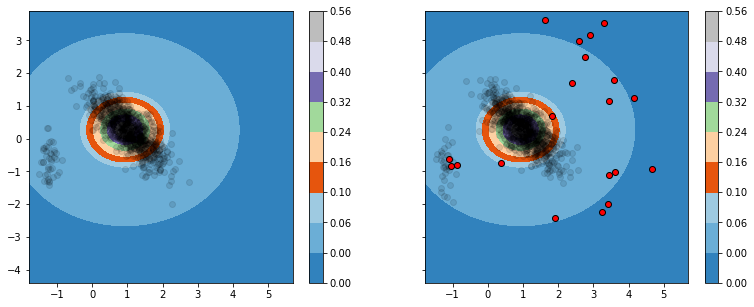

In [8]:
# densidade de probabilidade encontrada
def densidade(x1, x2):
    return normal(mu1, sg1, x1)*normal(mu2, sg2, x2)

# curvas de nivel representando diferentes escolhas de \varepsilon
n_values = 300
levels = [0.0, 0.000001, 0.06, 0.10, 0.16, 0.24, 0.32, 0.40, 0.48, 0.56]

print('x1: média '+str(np.round(mu1,3))+' e desv. pad.'+str(np.round(sg1,3)))
print('x2: média '+str(np.round(mu2,3))+' e desv. pad.'+str(np.round(sg2,3)))

PLOTANDO_MODELO_TREINADO(densidade, levels, n_values)

## 1.2) Escolhendo o hiper-parâmetro $\varepsilon$

Nesse momento variamos o valor de $\varepsilon$ que define as regiões de normalidade e escolhemos a que tem melhor resultado na validação.

In [9]:
def best_hiperparametro(tresholds, densidade, log):
    scores = {'limiar': [], 'log_limiar': [], 'recall': [], 'precisao': [], 'fbeta': []}

    for treshold in tqdm(tresholds):
        y_hat= []
        for i in range(valid.shape[0]):
            y_hat.append((densidade(valid.X1[i],valid.X2[i]) < treshold).astype(int))

        scores['limiar'].append(treshold)
        scores['log_limiar'].append(np.log(treshold))
        scores['recall'].append(recall_score(y_pred=y_hat, y_true=valid['y'].values))
        scores['precisao'].append(precision_score(y_pred=y_hat, y_true=valid['y'].values))
        scores['fbeta'].append(fbeta_score(y_pred=y_hat, y_true=valid['y'].values, beta=2))

    avaliando = pd.DataFrame(scores)
    best_limiar = avaliando.limiar[avaliando.fbeta.idxmax()]
    best_f_beta = avaliando.fbeta.max()
    
    if log:
        plt.plot(avaliando.log_limiar, avaliando.recall, label='$Recall$')
        plt.plot(avaliando.log_limiar, avaliando.precisao, label='$Precisão$')
        plt.plot(avaliando.log_limiar, avaliando.fbeta, label='$F_2$')
        plt.scatter([np.log(best_limiar)],[best_f_beta], c='black')
    else:
        plt.plot(avaliando.limiar, avaliando.recall, label='$Recall$')
        plt.plot(avaliando.limiar, avaliando.precisao, label='$Precisão$')
        plt.plot(avaliando.limiar, avaliando.fbeta, label='$F_2$')
        plt.scatter([best_limiar],[best_f_beta], c='black')

    plt.ylabel('Score')
    if log:
        plt.xlabel('log do Threshold')
    else:
        plt.xlabel('Threshold')
    plt.legend(loc='best')

    print(f'O melhor F_2 é {best_f_beta} e é obtido quando temos o limiar é {best_limiar}')
    
    return best_limiar, best_f_beta

100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


O melhor F_2 é 0.6698357821953327 e é obtido quando temos o limiar é 0.007090930978140022


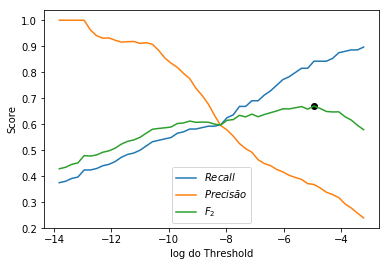

In [10]:
tresholds = np.geomspace(0.000001, 0.04, 50)

best_limiar_normal, best_f_beta_normal = best_hiperparametro(tresholds, densidade, log=True)

## 1.3) Avaliando no teste

Com o limiar escolhido anteriormente, testamos em dados nunca vistos para ter uma ideia do seu desempenho real.

In [11]:
def PLOTANDO_BEST_MODELO(densidade, levels, n_values):

    f, (ax2) = plt.subplots(1, 1, figsize = (5,5),sharey=True)

    # plot da validação
    x_vals = np.linspace(np.floor(10*valid.X1.min(axis=0)-2)/10, np.floor(10*valid.X1.max(axis=0)+2)/10, n_values)
    y_vals = np.linspace(np.floor(10*valid.X2.min(axis=0)-2)/10, np.floor(10*valid.X2.max(axis=0)+2)/10, n_values)

    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.asarray([[densidade(x,y) for x in x_vals ] for y in y_vals])

    cp2 = ax2.contourf(X, Y, Z, levels=levels, cmap='tab20c')

    cp = ax2.contour(X, Y, Z, levels=levels, cmap='tab20c')
    ax.clabel(cp, inline=True, fontsize=10, colors='black')
    f.colorbar(cp,ax=ax2)

    ax2.scatter(normal_test.drop(columns=['y']).X1[:1000],normal_test.drop(columns=['y']).X2[:1000],alpha=0.1,c='black')
    ax2.scatter(anormal_test.drop(columns=['y']).X1[:20],anormal_test.drop(columns=['y']).X2[:20],alpha=1,c='red',edgecolors='black')

    plt.show()

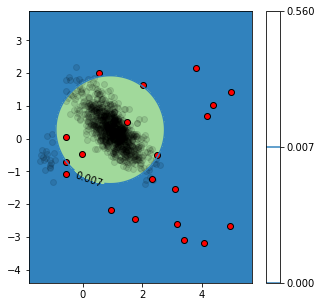

In [12]:
levels = [0.0, best_limiar_normal, 0.56]
n_values = 300

PLOTANDO_BEST_MODELO(densidade, levels, n_values)

In [13]:
COMPARACAO = {'método': [], 'acurácia no teste': [], 'recall no teste': [], 'precisão no teste': [], 'f_beta no teste': []}

def METRICAS_TESTE(densidade, best_limiar, metodo):
    
    if metodo == 'histograma':
        y_hat_test = (model_histograma.predict(test.drop('y', axis=1).values)<best_limiar_histograma).astype(int)
    elif metodo == 'gmm' or 'one class svm':
        y_hat_test = [(densidade(x,y)< best_limiar).astype(int) for x,y in zip(test.X1,test.X2)]
    else:
        y_hat_test = (densidade(test.X1,test.X2) < best_limiar).astype(int)
    
    print('acurácia no teste: '+ str(accuracy_score(y_pred=y_hat_test, y_true=test['y'].values)))
    print('recall no teste: ' + str(recall_score(y_pred=y_hat_test, y_true=test['y'].values)))
    print('precisão no teste: ' + str(precision_score(y_pred=y_hat_test, y_true=test['y'].values)))
    print('f_beta no teste: ' + str(fbeta_score(y_pred=y_hat_test, y_true=test['y'].values, beta=2)))

    COMPARACAO['método'].append(metodo)
    COMPARACAO['acurácia no teste'].append(accuracy_score(y_pred=y_hat_test, y_true=test['y'].values))
    COMPARACAO['recall no teste'].append(recall_score(y_pred=y_hat_test, y_true=test['y'].values))
    COMPARACAO['precisão no teste'].append(precision_score(y_pred=y_hat_test, y_true=test['y'].values))
    COMPARACAO['f_beta no teste'].append(fbeta_score(y_pred=y_hat_test, y_true=test['y'].values, beta=2))

In [14]:
METRICAS_TESTE(densidade, best_limiar_normal, 'gaussianas independentes')

acurácia no teste: 0.9520295202952029
recall no teste: 0.8432432432432433
precisão no teste: 0.41711229946524064
f_beta no teste: 0.7001795332136446


# 2) Assumindo um gaussiana multivariada

Nessa técnica, falamos que os exemplos normais são amostras de uma distribuição que tem função densidade de probabilidade dada por

$$ f (\textbf{x}) = \frac{1}{2\pi \textrm{ det}(\textbf{S}^{-1})} \, \exp \left( - \frac{1}{2} (\textbf{x} - \bar{\textbf{x}} )^{T} \,  \textbf{S} \,(\textbf{x} - \bar{\textbf{x}} ) \right),$$

em que $\textbf{S}$ é a matriz de covariância das amostras e $\bar{\textbf{x}}$ é o vetor de médias em cada componente.

Essa forma consegue visualizar a dependência que algumas variáveis podem ter.

## 2.1) Fitando a distribuição

In [15]:
from scipy.stats import multivariate_normal

mu = train.drop(columns=['y']).mean(axis=0)
sigma = train.drop(columns=['y']).cov().values
model_multivariate_normal = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

def densidade_new(x1, x2):
    return np.exp(model_multivariate_normal.logpdf([x1, x2]))

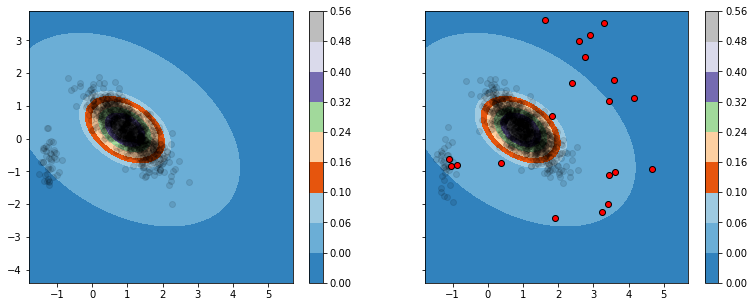

In [16]:
levels = [0.0, 0.000001, 0.06, 0.10, 0.16, 0.24, 0.32, 0.40, 0.48, 0.56]
n_values = 300

PLOTANDO_MODELO_TREINADO(densidade_new, levels, n_values)

## 2.2) Escolhendo o hiper-parâmetro $\varepsilon$

100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


O melhor F_2 é 0.7313707451701932 e é obtido quando temos o limiar é 0.005711940388817246


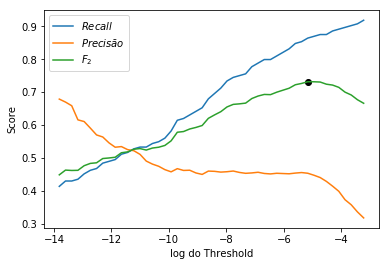

In [17]:
tresholds = np.geomspace(0.000001, 0.04, 50)

best_limiar_multivariada, best_f_beta_multivariada = best_hiperparametro(tresholds, densidade_new, log=True)

## 2.3) Avaliando no teste

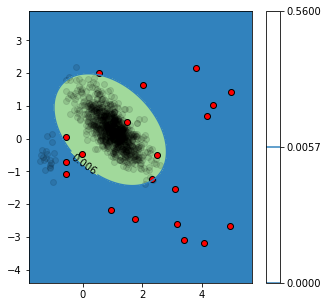

In [18]:
levels = [0.0, best_limiar_multivariada, 0.56]
n_values = 300

PLOTANDO_BEST_MODELO(densidade_new, levels, n_values)

In [19]:
METRICAS_TESTE(densidade_new, best_limiar_multivariada, 'gaussiana multivariada')

acurácia no teste: 0.9658186055544766
recall no teste: 0.8540540540540541
precisão no teste: 0.5146579804560261
f_beta no teste: 0.7545367717287489


# 3) Distribuição usando histogramas

Nem sempre a distribuição das nossas variáveis serão parecidas com uma normal. Em alguns casos faz sentido calcular o score baseado no número de exemplos do treino que são parecidos (caiem na mesma vizinhança).

Com essa motivação surge a ideia de tentar usar histogramas para modelar distribuições um pouco mais gerais.

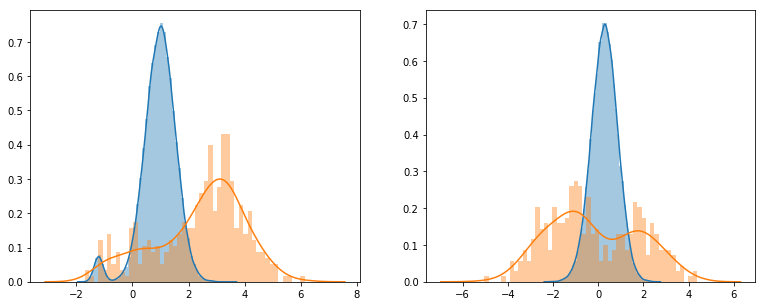

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (13,5),sharey=False)

sns.distplot(X1[y == 0], bins=50, label='Anormal',kde=True, ax=ax1)
sns.distplot(X1[y == 1], bins=50, label='Normal',kde=True, ax=ax1)
sns.distplot(X2[y == 0], bins=50, label='Anormal',kde=True, ax=ax2)
sns.distplot(X2[y == 1], bins=50, label='Normal',kde=True, ax=ax2)

plt.show()

## 3.1) Fitando a distribuição

In [21]:
class hist_model(object):
    
    def __init__(self, bins=50):
        self.bins = bins
        
    def fit(self, X):
        bin_hight, bin_edge = [], []
        for var in X.T:
            # calcula as alturas de cada bin e os extremos dos intervalos
            bh, bedge = np.histogram(var, bins=self.bins) 
            bin_hight.append(bh)
            bin_edge.append(bedge)
        self.bin_hight = np.array(bin_hight)
        self.bin_edge = np.array(bin_edge)

    def predict(self, X):
        scores = []
        for obs in X:
            obs_score = []
            for i, var in enumerate(obs):
                # para cada componente, encontramos em qual bin aquele exemplo cai
                bin_num = (var > self.bin_edge[i]).argmin()-1
                obs_score.append(self.bin_hight[i, bin_num]) # salva a altura do bin que o exemplo caiu, para cada componente
            
            ponto = 1
            for valor in obs_score:
                ponto = ponto*valor
            ponto = ponto**(1/len(obs_score))
            scores.append(ponto) 
            
            # scores.append(np.mean(obs_score)) # o score é simplesmente a média das alturas em cada componente
        return np.array(scores)
                
model_histograma = hist_model()
model_histograma.fit(df.drop('y', axis=1).values)

def densidade_hist(x1, x2):
    return model_histograma.predict(np.asarray([np.asarray([x1, x2])]))[0]


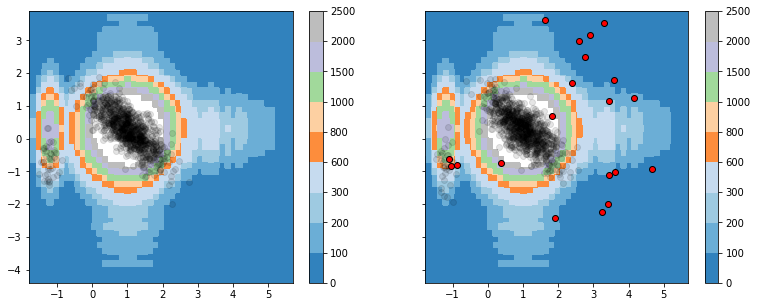

In [22]:
levels = [0.0, 100, 200, 300, 600, 800, 1000, 1500, 2000, 2500]
n_values = 300

PLOTANDO_MODELO_TREINADO(densidade_hist, levels, n_values)

## 3.2) Escolhendo o hiper-parâmetro $\varepsilon$

Neste caso temos outro hiper-parâmetro que pode ser importante: o número de bins que escolhemos para fazer o histograma. A princípio, neste momento também variaríamos esse hiper-parâmetro encontrando um que melhor se adapte aos dados de validação.

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


O melhor F_2 é 0.7294832826747721 e é obtido quando temos o limiar é 452.8571428571429


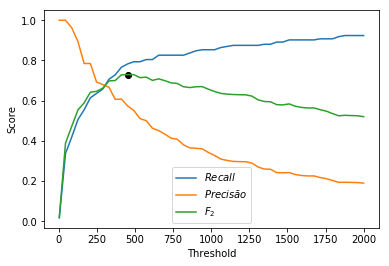

In [23]:
tresholds = np.linspace(5, 2000, 50)

best_limiar_histograma, best_f_beta_histograma = best_hiperparametro(tresholds, densidade_hist, log=False)

## 3.3) Avaliando no teste

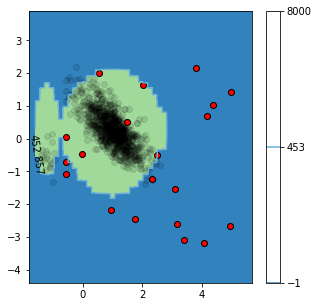

In [24]:
levels = [-1, best_limiar_histograma, 8000]
n_values = 300

PLOTANDO_BEST_MODELO(densidade_hist, levels, n_values)

In [25]:
METRICAS_TESTE(densidade_hist, best_limiar_histograma, 'histograma')

acurácia no teste: 0.9714507671392504
recall no teste: 0.7837837837837838
precisão no teste: 0.5753968253968254
f_beta no teste: 0.7308467741935484


# 4) Gaussian Mixture Model

Esse modelo assume que nossos dados são gerados por uma combinação de distribuições normais com diferentes médias e desvios padrões. A ideia é que ele tenta fitar as melhores gaussianas que aproximam nossos dados.

A implementação do sklearn nos dá ainda o log da verossimelhança relativa de um ponto do meu espaço. Isso será usado com score para escolher o threshold.

## 4.1) Fitando a distribuição

In [26]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, n_init=4)
gmm.fit(train.drop('y', axis=1).values)

def log_densidade_gmm(x1, x2):
    return gmm.score(np.asarray([np.asarray([x1,x2])]))

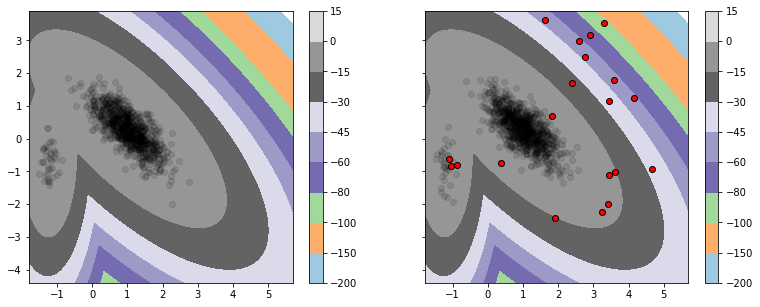

In [27]:
levels = [-200, -150, -100, -80, -60, -45, -30, -15, 0, 15]
n_values = 300

PLOTANDO_MODELO_TREINADO(log_densidade_gmm, levels, n_values)

## 4.2) Escolhendo o hiper-parâmetro $\varepsilon$

A principio também deveríamos mudar o número de clusters! Esse é um hiper-parâmetro muito importante, mas temos que tomar cuidado para não usarmos clusters demais e sofrer overfit.

100%|██████████| 40/40 [01:01<00:00,  1.52s/it]


O melhor F_2 é 0.8628318584070797 e é obtido quando temos o limiar é -6.153846153846154


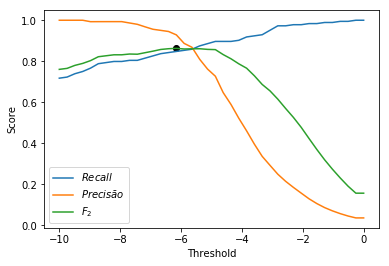

In [28]:
tresholds = np.linspace(-10, 0, 40)

best_limiar_gmm, best_f_beta_gmm = best_hiperparametro(tresholds, log_densidade_gmm, log=False)

## 4.3) Avaliando no teste

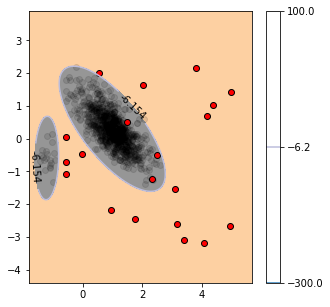

In [29]:
levels = [-300, best_limiar_gmm, 100]
n_values = 300

PLOTANDO_BEST_MODELO(log_densidade_gmm, levels, n_values)

In [30]:
METRICAS_TESTE(log_densidade_gmm, best_limiar_gmm, 'gmm')

acurácia no teste: 0.9914546513886191
recall no teste: 0.8648648648648649
precisão no teste: 0.8938547486033519
f_beta no teste: 0.8705114254624593


# 5) One Class Support Vector Machines

A ideia do One Class SVM é a parecida com a do SVM usual. Transformaremos nossos dados, levando eles para um espaço de características de dimensão maior com uma função

$$\phi:\mathbb{R}^n\to\mathbb{R}^m$$

com $n<m$ (a princípio $m$ não precisa ser finito, mas não importa). A partir daí podemos ter duas abordagens:

* Tentar separar todos os nossos exemplos do ponto 0 (origem) do espaço de atributos com um hiper-plano maximizando a distância do hiper-plano até a origem.

* Encontrar uma hiper-esfera de raio $R$ que engloba todos os exemplos em $\mathbb{R}^m$ tentando minimizar o raio $R$.

Novamente, podemos flexibilizar nossas fronteiras aceitando elementos do lado errado como no SVM clássico para classificação. Escrevendo tais métodos em uma forma adequada, utiliza-se de forma esperta os kernels para simplificar todos esse processo.

Recomendo a leitura desse [post](http://rvlasveld.github.io/blog/2013/07/12/introduction-to-one-class-support-vector-machines/).

## 5.1) Fitando a distribuição

In [31]:
from sklearn.svm import OneClassSVM
np.random.seed(42)

model_svm = OneClassSVM(gamma='auto', nu=0.05)
model_svm.fit(train.drop('y', axis=1).values)

def densidade_svm(x1, x2):
    return model_svm.score_samples(np.asarray([np.asarray([x1,x2])]))[0]

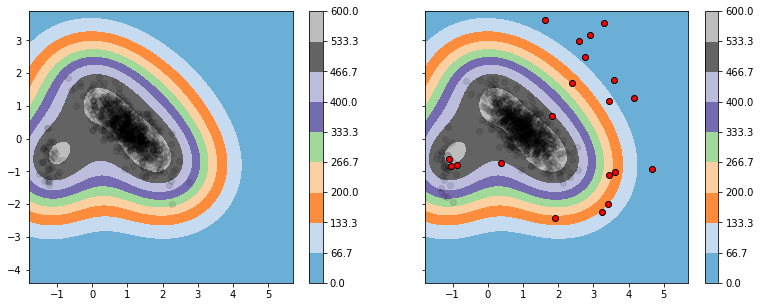

In [32]:
n_values = 100
levels = np.linspace(0,600,10)#[-200, -150, -100, -80, -60, -45, -30, -15, 0, 5]

PLOTANDO_MODELO_TREINADO(densidade_svm, levels, n_values)

## 5.2) Escolhendo o hiper-parâmetro $\varepsilon$

Nesse caso, temos muito hiper-parâmetros relevantes no SVM e essa parte é bem importante. Como só estamos experimentando os métodos não vale a pena fazer isso aqui.

100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


O melhor F_2 é 0.8057395143487859 e é obtido quando temos o limiar é 429.4871794871795


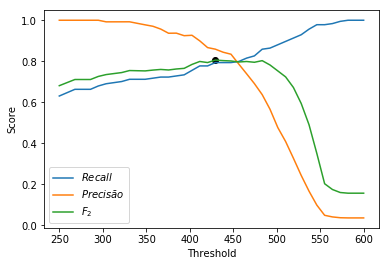

In [33]:
tresholds = np.linspace(250, 600, 40)

best_limiar_svm, best_f_beta_svm = best_hiperparametro(tresholds, densidade_svm, log=False)

## 5.3) Avaliando no teste

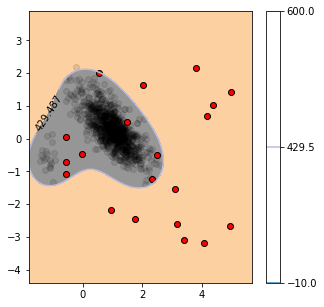

In [34]:
levels = [-10, best_limiar_svm, 600]
n_values = 100

PLOTANDO_BEST_MODELO(densidade_svm, levels, n_values)

In [35]:
METRICAS_TESTE(densidade_svm, best_limiar_svm, 'one class svm')

acurácia no teste: 0.9873761895513692
recall no teste: 0.7891891891891892
precisão no teste: 0.8488372093023255
f_beta no teste: 0.8004385964912281


# 6) Isololation Forest

O termo isolar significar 'separa aquele exemplo do resto dos dados'. Como anomalias se comportam como outliers da distribuição dos dados normais, elas são mais sucetíveis a serem separadas. Como nas Random Forests, criamos árvores que quebram os dados em folhas, mas aqui, até que cada folha esteja isolada em uma folha. Recursivamente, geramos partições dos dados selecionando aleatoriamente uma atributo e aleatoriamente um valor entre o máximo e o mínimo daquela variável.

A ideia é que essa quebra aleatória, em média produz, caminhos menores para anomalias. Um score é calculado levando em consideração o tamanho das quebras até cair em alguma folha.

<img src="isolation_forest.png">

Para mais detalhes, recomendo a [página da Wikipedia](https://en.wikipedia.org/wiki/Isolation_forest) que explica o algoritmo.

In [36]:
from sklearn.ensemble import IsolationForest

model_tree = IsolationForest(max_samples=train.shape[0], bootstrap=True, n_estimators=60)
model_tree.fit(train.drop('y', axis=1).values)

IsolationForest(behaviour='old', bootstrap=True, contamination='legacy',
        max_features=1.0, max_samples=39704, n_estimators=60, n_jobs=None,
        random_state=None, verbose=0)

In [37]:
def densidade_forest(x1, x2):
    return model_tree.decision_function(np.asarray([np.asarray([x1,x2])]))[0]

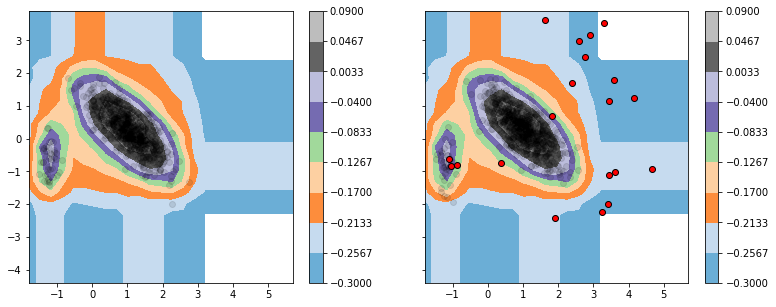

In [38]:
n_values = 25
levels = np.linspace(-0.3, 0.09,10)

PLOTANDO_MODELO_TREINADO(densidade_forest, levels, n_values)

## 6.2) Escolhendo o hiper-parâmetro $\varepsilon$

Novamente, existem muitos hiper-parâmetros que são relevantes aqui, e se queremos usar esse método na prática, demos entende-los e otimizá-los.

100%|██████████| 15/15 [20:51<00:00, 81.98s/it]

O melhor F_2 é 0.8533916849015317 e é obtido quando temos o limiar é -0.1285714285714286


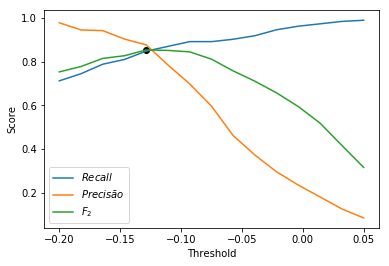

In [39]:
tresholds = np.linspace(-0.2, 0.05,15)

best_limiar_forest, best_f_beta_forest = best_hiperparametro(tresholds, densidade_forest, log=False)

## 6.3) Avaliando no teste

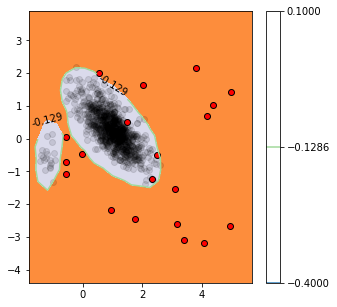

In [40]:
levels = [-0.4, best_limiar_forest, 0.1]
n_values = 25

PLOTANDO_BEST_MODELO(densidade_forest, levels, n_values)

In [41]:
METRICAS_TESTE(densidade_forest, best_limiar_forest, 'isolation forest')

acurácia no teste: 0.9904835890464168
recall no teste: 0.8810810810810811
precisão no teste: 0.8578947368421053
f_beta no teste: 0.8763440860215054


# Comparação dos diferentes métodos

Apesar da utilização em uma dataset toy, podemos ver algumas vantagens e desvantagens dos métodos.

In [42]:
pd.DataFrame(COMPARACAO).sort_values('f_beta no teste')

,método,acurácia no teste,recall no teste,precisão no teste,f_beta no teste
0,gaussianas independentes,0.952030,0.843243,0.417112,0.700180
2,histograma,0.971451,0.783784,0.575397,0.730847
1,gaussiana multivariada,0.965819,0.854054,0.514658,0.754537
4,one class svm,0.987376,0.789189,0.848837,0.800439
3,gmm,0.991455,0.864865,0.893855,0.870511
5,isolation forest,0.990484,0.881081,0.857895,0.876344
